# CHIDO MAYOTTE 

## Importation des packages et du dataset

In [50]:
#!pip install nltk

import pandas as pd
import numpy as np
import unicodedata

import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import nltk

pd.options.display.max_columns = 100

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, r2_score, mean_squared_error, ConfusionMatrixDisplay, classification_report

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_list = stopwords.words('french')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laitissia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
## Importer les données 
facebook_posts = pd.read_csv("facebook_posts.csv")
facebook_comments = pd.read_csv("facebook_comments.csv")


In [26]:
facebook_posts.head()

,post_id,from_id,from_name,created_time,message,permalink_url,type,likes_count,comments_count,shares_count
0,1,user_80,Utilisateur_15,2024-12-03 01:24:14,Information sur les zones d'évacuation,https://facebook.com/post/1,link,183,3,0
1,2,user_100,Utilisateur_49,2024-12-06 07:39:14,Signalement de routes bloquées,https://facebook.com/post/2,video,2,17,28
2,3,user_94,Utilisateur_30,2024-11-21 17:00:14,Recherches de familles disparues après la crue,https://facebook.com/post/3,video,274,3,45
3,4,user_38,Utilisateur_29,2024-12-09 17:09:14,Recherche de la famille perdue à cause du cyclone,https://facebook.com/post/4,image,417,6,46
4,5,user_26,Utilisateur_48,2024-12-10 12:39:14,Chute d'arbres signalée sur la route principale,https://facebook.com/post/5,video,66,8,40


In [ ]:
# Je veux vérifier le type de chaque colonne pour la base de données "facebook_posts"
facebook_posts.dtypes

post_id            int64
from_id           object
from_name         object
created_time      object
message           object
permalink_url     object
type              object
likes_count        int64
comments_count     int64
shares_count       int64
dtype: object

In [ ]:
# je veux changer le type de la colonne "created_time" en datetime
facebook_posts["created_time"] = pd.to_datetime(facebook_posts["created_time"])

# je veux vérifier si le changement a été effectué
facebook_posts.dtypes

post_id                    int64
from_id                   object
from_name                 object
created_time      datetime64[ns]
message                   object
permalink_url             object
type                      object
likes_count                int64
comments_count             int64
shares_count               int64
dtype: object

In [20]:
# je veux vérifier s'il y a des valeurs manquantes dans la base de données "facebook_posts"
facebook_posts.isnull().sum()

post_id           0
from_id           0
from_name         0
created_time      0
message           0
permalink_url     0
type              0
likes_count       0
comments_count    0
shares_count      0
dtype: int64

In [22]:
# je veux un résumé des données de la base de données "facebook_posts"
facebook_posts.describe()

,post_id,created_time,likes_count,comments_count,shares_count
count,500.000000,500,500.00000,500.000000,500.000000
mean,250.500000,2024-12-04 06:40:08.959999744,246.42800,9.894000,25.640000
min,1.000000,2024-11-18 15:53:14,0.00000,0.000000,0.000000
25%,125.750000,2024-11-27 01:17:44,115.00000,4.000000,14.000000
50%,250.500000,2024-12-04 11:51:14,247.50000,10.000000,26.000000
75%,375.250000,2024-12-12 03:04:14,371.25000,15.000000,38.000000
max,500.000000,2024-12-19 13:27:14,500.00000,20.000000,50.000000
std,144.481833,NaN,147.50637,5.985852,14.358926


In [23]:
# je veux un résumé des données de la base de données "facebook_posts" pour les variables catégorielles
facebook_posts.describe(include="object")

,from_id,from_name,message,permalink_url,type
count,500,500,500,500,500
unique,100,99,20,500,4
top,user_35,Utilisateur_19,Chute d'arbres signalée sur la route principale,https://facebook.com/post/1,image
freq,11,10,32,1,140


array([[<Axes: title={'center': 'post_id'}>,
        <Axes: title={'center': 'created_time'}>],
       [<Axes: title={'center': 'likes_count'}>,
        <Axes: title={'center': 'comments_count'}>],
       [<Axes: title={'center': 'shares_count'}>, <Axes: >]], dtype=object)

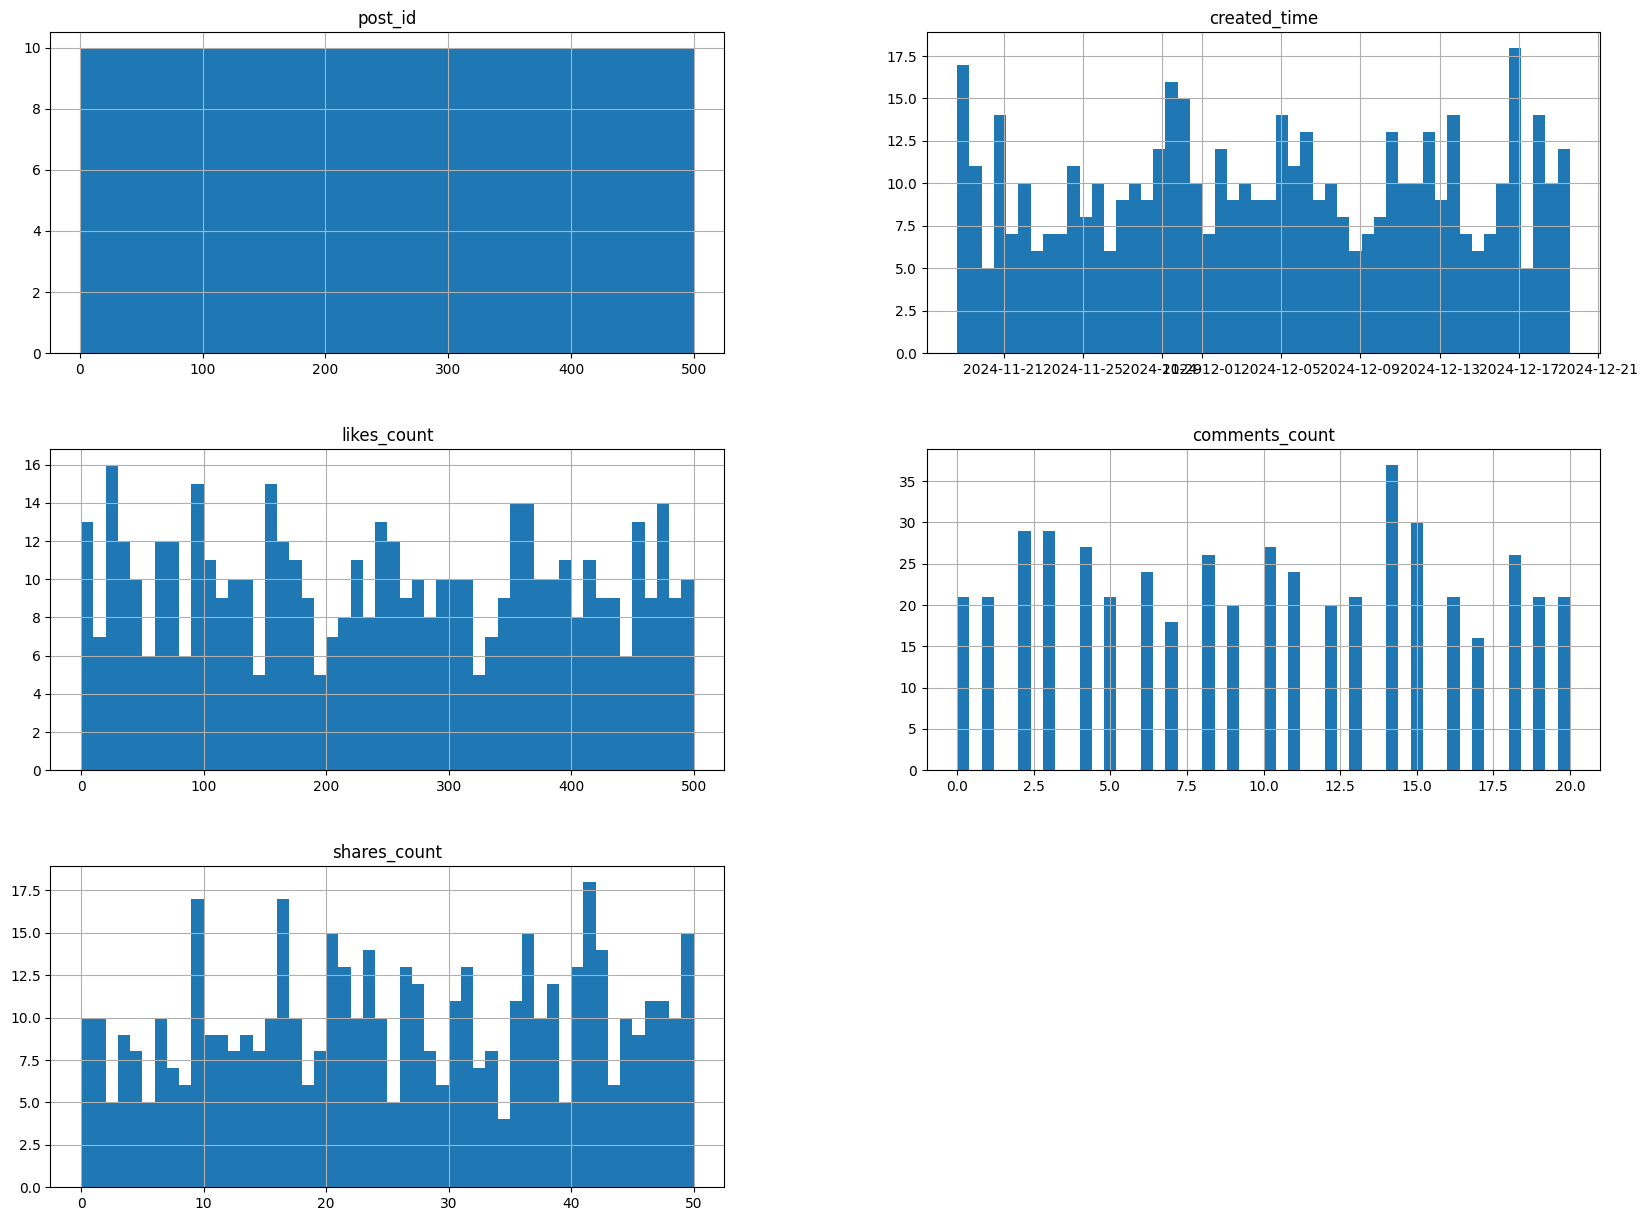

In [24]:
# je veux visualiser rapidement les données de la base de données "facebook_posts"
facebook_posts.hist(bins=50, figsize=(20,15))

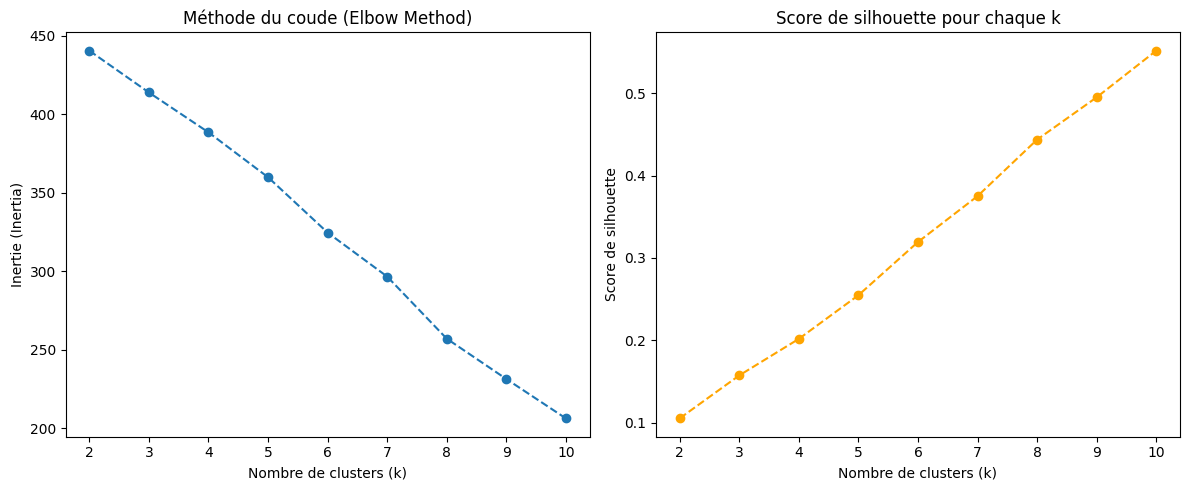

In [52]:
# Pour la colonne message, je veux faire ressortir des groupes de message qui se ressemble pour faire ressortir des catégories de message

# Nettoyer la colonne "message"
# Supprimer les majuscules, ponctuations et caractères spéciaux
facebook_posts['cleaned_message'] = facebook_posts['message'].str.lower().str.replace('[^a-zA-Z\s]', '', regex=True)

# Appliquer TF-IDF sur la colonne 'cleaned_message'
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_list, max_features=1000)  # On limite à 1000 mots les plus importants
tfidf_matrix = tfidf_vectorizer.fit_transform(facebook_posts['cleaned_message'])

# Méthode du coude (Elbow Method) : pour chercher le nombre de clusters optimal
inertias = []
silhouette_scores = []
k_range = range(2, 11)  # On teste de 2 à 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(tfidf_matrix, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# 2️⃣ Visualiser la méthode du coude (Elbow) et le score de silhouette
plt.figure(figsize=(12, 5))

# Courbe d'inertie (Elbow method)
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o', linestyle='--')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (Inertia)')
plt.title('Méthode du coude (Elbow Method)')

# Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--', color='orange')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette pour chaque k')

plt.tight_layout()
plt.show()


In [15]:
# Je veux vérifier le type de chaque colonne pour la base de données "facebook_comments"
facebook_comments.dtypes

comment_id      object
post_id          int64
from_id         object
from_name       object
created_time    object
message         object
like_count       int64
dtype: object